<a href="https://colab.research.google.com/github/ramcan7/SkinCancerDetection_TA_IA/blob/main/SkinCancerDetectionFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detección de Cáncer en la Piel
ISIC

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
#indicamos donde esta ubicado el dataset
dataset_path = '/content/drive/MyDrive/SkinCancerDetection/'
train_target_path = dataset_path + 'ISBI2016_ISIC_Part3_Training_GroundTruth.csv'
train_images_path = dataset_path + 'ISBI2016_ISIC_Part3_Training_Data/'
test_target_path = dataset_path + 'ISBI2016_ISIC_Part3_Test_GroundTruth.csv'
test_images_path = dataset_path + 'ISBI2016_ISIC_Part3_Test_Data/'

# Directorios en Google Drive
augmented_dir = dataset_path + 'Augmented_images/Minority_class'


In [3]:
from sklearn.preprocessing import LabelEncoder
#se lee la informacion de asignaicon
train_target = pd.read_csv(train_target_path)
train_target.head(5)
train_target.groupby(by="label").size()

# Inicializar y ajustar el codificador
label_encoder = LabelEncoder()
#Solo se codifica del train, porque de los datos de test están en números
train_target['label'] = label_encoder.fit_transform(train_target['label'])
train_target.groupby(by="label").size()
#el dataset se encuentra desbalanceado

,0
label,
0,727
1,173


#ISICDataset
Es una clase personalizada para la carga de las imágenes y el target desde el directorio que se le indique.

In [4]:
from torch.utils.data import Dataset
from PIL import Image
import os

class ISICDataset(Dataset):
  def __init__(self, dataframe, img_dir, transform=None):
    self.dataframe = dataframe
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
        return len(self.dataframe)

  def __getitem__(self, idx):
      row = self.dataframe.iloc[idx]
      img_path = os.path.join(self.img_dir, row['image_id'] + '.jpg')  # Adjust extension if needed
      image = Image.open(img_path).convert("RGB")
      label = row['label']
      #print(type(image))
      #print(label)

      if self.transform:
          image = self.transform(image)

      return image, label

##1. Aumentando los datos
Para ello, en primer lugar aumentaremos la cantidad de datos de esta clase usando rotaciones y reflejos.

In [ ]:
from torchvision import transforms

augmentation = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])

# Preprocesamiento de imágenes

Se normaliza las imágenes, a partir de la media y la desviación estándar.

In [5]:
from PIL import Image
import numpy as np
import os

def calculate_channel_mean_std(directory):
  sum_means = np.array([0.0, 0.0, 0.0])
  sum_variances = np.array([0.0, 0.0, 0.0])
  pixel_count = 0

  for filename in os.listdir(directory):
    if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
      filepath = os.path.join(directory, filename)
      with Image.open(filepath) as img:
        img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize pixel values
        if img_array.ndim == 3:  # Ensure the image is RGB
          batch_sum = np.sum(img_array, axis=(0, 1))
          batch_sum_sq = np.sum(np.square(img_array), axis=(0, 1))
          sum_means += batch_sum
          sum_variances += batch_sum_sq
          pixel_count += img_array.shape[0] * img_array.shape[1]

  mean = sum_means / pixel_count
  std = np.sqrt((sum_variances / pixel_count) - np.square(mean))

  return mean, std

In [6]:
directory_path = train_images_path
#mean, std = calculate_channel_mean_std(directory_path)
#print(f"Mean (RGB): {mean}, Standard Deviation (RGB): {std}")

In [7]:
directory_path = test_images_path
#mean, std = calculate_channel_mean_std(directory_path)
#print(f"Mean (RGB): {mean}, Standard Deviation (RGB): {std}")

In [8]:
import numpy as np
mean = np.array([0.71915714, 0.58844729, 0.53855692])
std = np.array([0.04349885, 0.21068188, 0.19393109])

#Balanceando datos

In [9]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])



Creamos la división entre entrenamiento y validación

In [10]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_target, test_size=0.2, stratify=train_target['label'], random_state=42)

Identificamos las clases mayoritarias y minoritarias

In [11]:
from torch.utils.data import Subset

# Supongamos que dataset.targets contiene las etiquetas
minority_class_indices = [i for i, label in enumerate(train_df.label) if label == 1]  # Clase minoritaria
majority_class_indices = [i for i, label in enumerate(train_df.label) if label == 0]  # Clase mayoritaria

# Crear subconjuntos
minority_subset = Subset(train_df, minority_class_indices)
majority_subset = Subset(train_df, majority_class_indices)

In [12]:
#primero agregamos los datos del augmented

# Crear un nuevo DataFrame para las imágenes aumentadas
augmented_data = []
for file_name in os.listdir(augmented_dir):
    image_id = file_name.split('.')[0]
    augmented_data.append({'image_id': image_id, 'label': 1})

augmented_df = pd.DataFrame(augmented_data)

In [13]:
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

train_dataset = ISICDataset(dataframe=train_df, img_dir=train_images_path, transform=transform)
train_aug_dataset = ISICDataset(dataframe=augmented_df, img_dir=augmented_dir, transform=transform)
train_full_dataset = ConcatDataset([train_dataset, train_aug_dataset])
val_dataset = ISICDataset(dataframe=val_df, img_dir=train_images_path, transform=transform)

#Creamos nuevas imágenes

In [ ]:
from torchvision import transforms
from PIL import Image
import os

# Transformaciones para la clase minoritaria
minority_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224))
])

# Crear directorio si no existe
os.makedirs(augmented_dir, exist_ok=True)

def save_augmented_images(dataframe, img_dir, transform, output_dir, class_name, num_augmentations=5):
    for idx, row in dataframe.iterrows():
        if row['label'] == 1:
            img_path = os.path.join(img_dir, row['image_id'] + '.jpg')
            image = Image.open(img_path).convert("RGB")
            for i in range(num_augmentations):
                augmented_image = transform(image)
                save_path = os.path.join(output_dir, f"{row['image_id']}_aug{i}.jpg")
                augmented_image.save(save_path)
                #print(f"Saved: {save_path}")


In [ ]:
save_augmented_images(
    train_df,
    img_dir=train_images_path,
    transform=minority_transforms,
    output_dir=augmented_dir,
    class_name='minority_class',
    num_augmentations=3
)

#Cargamos el dataset

In [14]:
train_loader = DataLoader(train_full_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [15]:
def denormalize(image):
    for img, m, s in zip(image, mean, std):
        img.mul_(s).add_(m)
    return image

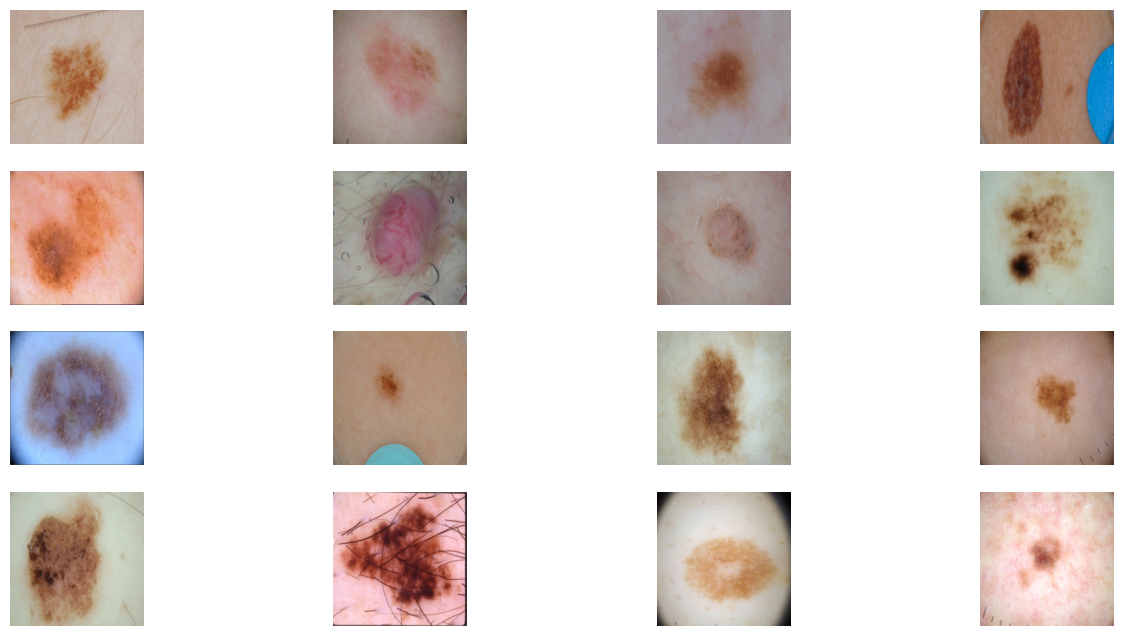

In [ ]:
images, labels = next(iter(train_loader))
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.imshow(denormalize(images[i]).permute(1,2,0))


#Usando cross_entropy

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
# Cargar ResNet preentrenado

model.fc = nn.Linear(model.fc.in_features, len(train_target['label'].unique()))

# Configurar el dispositivo para GPU si está disponible, de lo contrario usar CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


class_weights = torch.tensor([1.0,  4.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

#Usando focal_loss

In [16]:
import torch.nn.functional as F
import torch
import torch.nn as nn
from torchvision import models

model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
# Cargar ResNet preentrenado
# Ajustar la última capa para clasificación binaria
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 1)
)

# Configurar el dispositivo para GPU si está disponible, de lo contrario usar CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0):
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    pt = torch.exp(-BCE_loss)
    loss = alpha * (1 - pt) ** gamma * BCE_loss
    return loss.mean()

# Usar la Focal Loss en lugar de CrossEntropyLoss
criterion = focal_loss

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 78.8MB/s]


cuda


In [20]:
import time

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start_epoch = time.time()
    i=0
    for batch in train_loader:
        start_bach = time.time()
        images, labels = batch[0], batch[1]
        #labels = labels.unsqueeze(1)
        labels = labels.unsqueeze(1).float()
        images, labels = images.to(device), labels.to(device)
        # Añadir dimensión extra a las etiquetas

        # Reiniciar gradientes
        optimizer.zero_grad()

        # Forward
        outputs = model(images)
        #outputs = torch.sigmoid(model(images))
        #predictions = (outputs > 0.5).int()  # Umbral en 0.5 para predicción binaria
        #print(labels)
        #print(outputs)
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        end_bach = time.time()
        print(f"Epoch {epoch+1} - Bach{i+1}, time: {end_bach - start_bach:.2f} seconds")
        i+=1
    end_epoch = time.time()
    print(f"Epoch {epoch+1}, time: {end_epoch - start_epoch:.2f} seconds")
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")


Epoch 1 - Bach1, time: 1.18 seconds
Epoch 1 - Bach2, time: 0.54 seconds
Epoch 1 - Bach3, time: 0.59 seconds
Epoch 1 - Bach4, time: 0.60 seconds
Epoch 1 - Bach5, time: 0.61 seconds
Epoch 1 - Bach6, time: 0.62 seconds
Epoch 1 - Bach7, time: 0.61 seconds
Epoch 1 - Bach8, time: 0.59 seconds
Epoch 1 - Bach9, time: 0.62 seconds
Epoch 1 - Bach10, time: 0.62 seconds
Epoch 1 - Bach11, time: 0.59 seconds
Epoch 1 - Bach12, time: 0.59 seconds
Epoch 1 - Bach13, time: 0.62 seconds
Epoch 1 - Bach14, time: 0.59 seconds
Epoch 1 - Bach15, time: 0.55 seconds
Epoch 1 - Bach16, time: 0.60 seconds
Epoch 1 - Bach17, time: 0.54 seconds
Epoch 1 - Bach18, time: 0.47 seconds
Epoch 1, time: 148.13 seconds
Epoch 1, Loss: 0.021968824685447745
Epoch 2 - Bach1, time: 0.64 seconds
Epoch 2 - Bach2, time: 0.54 seconds
Epoch 2 - Bach3, time: 0.61 seconds
Epoch 2 - Bach4, time: 0.54 seconds
Epoch 2 - Bach5, time: 0.63 seconds
Epoch 2 - Bach6, time: 0.54 seconds
Epoch 2 - Bach7, time: 0.59 seconds
Epoch 2 - Bach8, time: 0.

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a935dc56f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a935dc56f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 7 - Bach1, time: 0.61 seconds
Epoch 7 - Bach2, time: 0.60 seconds
Epoch 7 - Bach3, time: 0.55 seconds
Epoch 7 - Bach4, time: 0.55 seconds
Epoch 7 - Bach5, time: 0.55 seconds
Epoch 7 - Bach6, time: 0.55 seconds
Epoch 7 - Bach7, time: 0.59 seconds
Epoch 7 - Bach8, time: 0.55 seconds
Epoch 7 - Bach9, time: 0.62 seconds
Epoch 7 - Bach10, time: 0.55 seconds
Epoch 7 - Bach11, time: 0.62 seconds
Epoch 7 - Bach12, time: 0.56 seconds
Epoch 7 - Bach13, time: 0.59 seconds
Epoch 7 - Bach14, time: 0.55 seconds
Epoch 7 - Bach15, time: 0.61 seconds
Epoch 7 - Bach16, time: 0.55 seconds
Epoch 7 - Bach17, time: 0.61 seconds
Epoch 7 - Bach18, time: 0.40 seconds
Epoch 7, time: 37.14 seconds
Epoch 7, Loss: 0.009194317273795605


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a935dc56f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a935dc56f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 8 - Bach1, time: 0.59 seconds
Epoch 8 - Bach2, time: 0.55 seconds
Epoch 8 - Bach3, time: 0.60 seconds
Epoch 8 - Bach4, time: 0.55 seconds
Epoch 8 - Bach5, time: 0.63 seconds
Epoch 8 - Bach6, time: 0.55 seconds
Epoch 8 - Bach7, time: 0.61 seconds
Epoch 8 - Bach8, time: 0.56 seconds
Epoch 8 - Bach9, time: 0.61 seconds
Epoch 8 - Bach10, time: 0.55 seconds
Epoch 8 - Bach11, time: 0.55 seconds
Epoch 8 - Bach12, time: 0.55 seconds
Epoch 8 - Bach13, time: 0.55 seconds
Epoch 8 - Bach14, time: 0.55 seconds
Epoch 8 - Bach15, time: 0.61 seconds
Epoch 8 - Bach16, time: 0.61 seconds
Epoch 8 - Bach17, time: 0.55 seconds
Epoch 8 - Bach18, time: 0.40 seconds
Epoch 8, time: 34.26 seconds
Epoch 8, Loss: 0.0059873425246526795


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a935dc56f80>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a935dc56f80>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 9 - Bach1, time: 0.60 seconds
Epoch 9 - Bach2, time: 0.55 seconds
Epoch 9 - Bach3, time: 0.63 seconds
Epoch 9 - Bach4, time: 0.55 seconds
Epoch 9 - Bach5, time: 0.59 seconds
Epoch 9 - Bach6, time: 0.55 seconds
Epoch 9 - Bach7, time: 0.61 seconds
Epoch 9 - Bach8, time: 0.55 seconds
Epoch 9 - Bach9, time: 0.63 seconds
Epoch 9 - Bach10, time: 0.55 seconds
Epoch 9 - Bach11, time: 0.55 seconds
Epoch 9 - Bach12, time: 0.56 seconds
Epoch 9 - Bach13, time: 0.61 seconds
Epoch 9 - Bach14, time: 0.55 seconds
Epoch 9 - Bach15, time: 0.61 seconds
Epoch 9 - Bach16, time: 0.55 seconds
Epoch 9 - Bach17, time: 0.55 seconds
Epoch 9 - Bach18, time: 0.40 seconds
Epoch 9, time: 34.25 seconds
Epoch 9, Loss: 0.006350764131639153
Epoch 10 - Bach1, time: 0.63 seconds
Epoch 10 - Bach2, time: 0.55 seconds
Epoch 10 - Bach3, time: 0.55 seconds
Epoch 10 - Bach4, time: 0.57 seconds
Epoch 10 - Bach5, time: 0.63 seconds
Epoch 10 - Bach6, time: 0.55 seconds
Epoch 10 - Bach7, time: 0.55 seconds
Epoch 10 - Bach8, t

In [24]:
from sklearn.metrics import classification_report

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))
        preds = (outputs > 0.5).int()

        #_, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.79      0.82       145
           1       0.33      0.43      0.37        35

    accuracy                           0.72       180
   macro avg       0.59      0.61      0.59       180
weighted avg       0.75      0.72      0.73       180



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

num_classes = 2
class_labels = [str(i) for i in range(num_classes)]

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

In [ ]:
print(preds)
print(y_true)
print(y_pred)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0], device='cuda:0')
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

#Evaluacion en el test dataset

In [ ]:
test_df = pd.read_csv(test_target_path)
test_dataset = ISICDataset(dataframe=test_df, img_dir=test_images_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.81      0.86       304
         1.0       0.46      0.67      0.55        75

    accuracy                           0.78       379
   macro avg       0.69      0.74      0.70       379
weighted avg       0.82      0.78      0.79       379



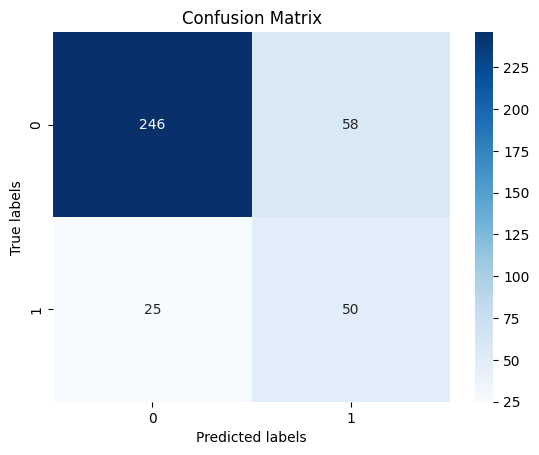

In [ ]:
num_classes = 2
class_labels = [str(i) for i in range(num_classes)]

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()